# Minimisation using MINUIT and scipy.optimize

In this notebook I have a quick play with scipy.optimize and MINUIT to compare their performance for a simple minimisation problem using a negative log-likelihood function (since this is the typical function that we try to minismise in particle physics when determining the best parameters of a model to describe a particular dataset). MINUIT (https://github.com/iminuit/iminuit) is installed by doing

$ pip install iminuit

Some instructions below show how to use the MINUIT interface.

In [204]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='serif', size=220)
import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = 8, 8
pylab.rcParams.update({'font.size': 15})

In [205]:
from iminuit import Minuit, describe
from iminuit.util import make_func_code
from scipy.optimize import minimize

First lets generate a dataset for fitting - a simple Gaussian distribution.

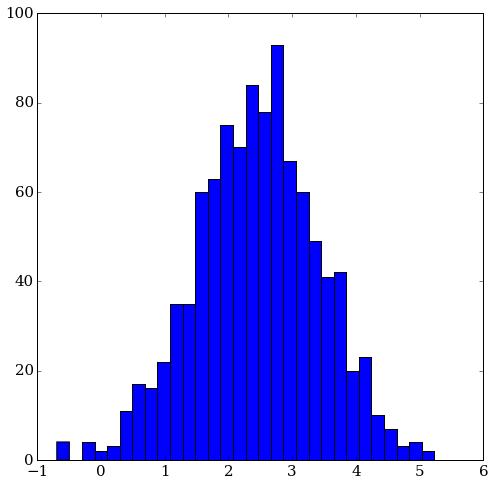

In [206]:
mu, sigma = 2.5, 1. # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 30)

Now let's build the function that we want to fit. It's an unbinned maximum likelihood fit of a Gaussian distribution, so we need to build the likelihood function.

In [207]:
def gauss(x, mu, sigma):
    return 1./(np.sqrt(2 * np.pi*sigma**2)) * np.exp( - (x - mu)**2 / (2 * sigma**2) )

In [208]:
class LogLikelihood:
    """Need this for MINUIT. We can pass in any function
    and data we want using this class."""
    def __init__(self, f, data):
        self.f = f
        self.data = data
        f_sig = describe(f)
        # this is how you fake function 
        # signature dynamically
        self.func_code = make_func_code(f_sig[1:]) # docking off independent variable
        self.func_defaults = None # this keeps np.vectorize happy
    def __call__(self, *args): # lets try to find mu and sigma
        NLL = -np.log( self.f(self.data, *args)).sum()
        return NLL

def LLwrapper(params):
    """Need this for scipy.optimize. There might be a better way of doing it."""
    NLL = LogLikelihood(gauss, s)
    return NLL(params[0], params[1])

Check that the likelihood (and wrapper) are doing the correct thing.

In [209]:
NLL = LogLikelihood(gauss, s)
print NLL(2., 2.)
print LLwrapper([2.,2.])

1754.36580125
1754.36580125


Now let's minimise the function using the BFGS method in scipy.optimize.minimize. The BFGS method is bascially what MINUIT is doing. In this case, the BFGS method doesn't have the ability to handle bounds on the parameter values, however, it will return the inverse Hessian matrix, which is what we need to get the uncertainty on the fitted parameters. scipy also has the option of using the L-BFGS-B method, where L stands for limited memory and B for bounded parameters. However, in this case the algorithm doesn't keep a copy of the Hessian in memory and, as such, cannot give the inverse Hessian as an output from the fit. If using this algortihm then parameter unceratinties need to be determined using another method (toys, bootstaps, jackknife...).

In [210]:
initial_values = np.array([2.,2.])
res = minimize(LLwrapper, initial_values,  method='BFGS', options={'gtol': 1e-4})
print res

   status: 0
  success: True
     njev: 19
     nfev: 76
 hess_inv: array([[  9.43731948e-04,   6.83159672e-06],
       [  6.83159672e-06,   4.65087683e-04]])
      fun: 1385.6897575015837
        x: array([ 2.45008385,  0.96729788])
  message: 'Optimization terminated successfully.'
      jac: array([  0.00000000e+00,  -1.52587891e-05])


In [211]:
from numpy.linalg import inv
print inv(res.hess_inv)

[[ 1059.73560007   -15.56628246]
 [  -15.56628246  2150.36084197]]


Now we can do the minimisation with MINUIT.

In [212]:
describe(NLL)

['mu', 'sigma']

In [213]:
m = Minuit(NLL, mu = initial_values[0], sigma = initial_values[1], error_mu=0.5, error_sigma=0.5, print_level=1, errordef=0.5)
m.print_param()
result = m.migrad() # hesse called at the end of migrad
m.print_matrix()
print(m.values)
print(m.errors)
print result

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mu,2,0.5,0,0,,,
2,sigma,2,0.5,0,0,,,


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log


FCN = 1385.68975762 
 TOTAL NCALL = 64 
 NCALLS = 64 
 
 
 EDM = 1.18037974432e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mu,2.45007,0.0305886,0,0,,,
2,sigma,0.967295,0.0216293,0,0,,,


+,mu,sigma
mu,1.00,0.00
sigma,0.00,1.00


{'mu': 2.4500694862323336, 'sigma': 0.9672952592050953}
{'mu': 0.030588566572218957, 'sigma': 0.021629286631555975}
({'hesse_failed': False, 'has_reached_call_limit': False, 'has_accurate_covar': True, 'has_posdef_covar': True, 'up': 0.5, 'edm': 1.1803797443167693e-07, 'is_valid': True, 'is_above_max_edm': False, 'has_covariance': True, 'has_made_posdef_covar': False, 'has_valid_parameters': True, 'fval': 1385.689757619587, 'nfcn': 64}, [{'is_const': False, 'name': 'mu', 'has_limits': False, 'value': 2.4500694862323336, 'number': 0, 'has_lower_limit': False, 'upper_limit': 0.0, 'lower_limit': 0.0, 'has_upper_limit': False, 'error': 0.030588566572218957, 'is_fixed': False}, {'is_const': False, 'name': 'sigma', 'has_limits': False, 'value': 0.9672952592050953, 'number': 1, 'has_lower_limit': False, 'upper_limit': 0.0, 'lower_limit': 0.0, 'has_upper_limit': False, 'error': 0.021629286631555975, 'is_fixed': False}])


One of the (many) benefits of MINUIT are the in-built methods for drawing the likelihood surface in 1D or 2D. e.g., 

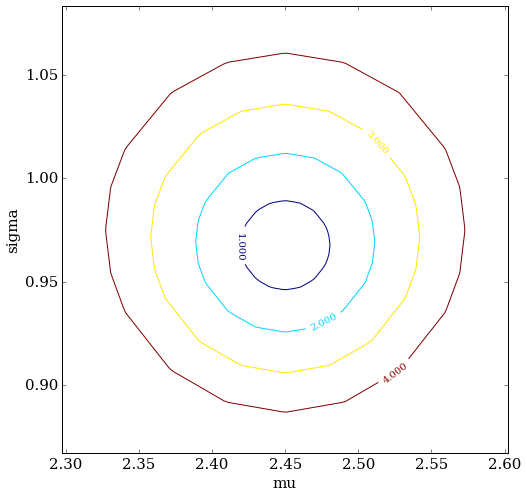

In [214]:
m.draw_mncontour('mu','sigma', nsigma=4);

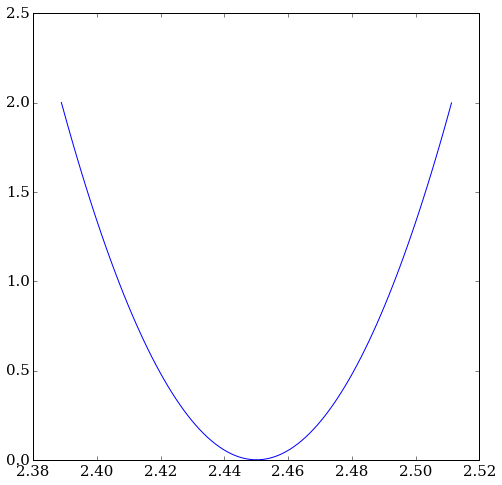

In [215]:
#1D value Scan
x,y = m.profile('mu',subtract_min=True);
plt.plot(x,y) #if you have matplotlib

This is an inbuilt method for doing the same thing as above (this time for sigma).

(array([ 0.92403669,  0.9249106 ,  0.92578451,  0.92665842,  0.92753233,
         0.92840624,  0.92928015,  0.93015406,  0.93102797,  0.93190188,
         0.93277579,  0.9336497 ,  0.93452361,  0.93539752,  0.93627143,
         0.93714534,  0.93801926,  0.93889317,  0.93976708,  0.94064099,
         0.9415149 ,  0.94238881,  0.94326272,  0.94413663,  0.94501054,
         0.94588445,  0.94675836,  0.94763227,  0.94850618,  0.94938009,
         0.950254  ,  0.95112791,  0.95200182,  0.95287573,  0.95374965,
         0.95462356,  0.95549747,  0.95637138,  0.95724529,  0.9581192 ,
         0.95899311,  0.95986702,  0.96074093,  0.96161484,  0.96248875,
         0.96336266,  0.96423657,  0.96511048,  0.96598439,  0.9668583 ,
         0.96773221,  0.96860613,  0.96948004,  0.97035395,  0.97122786,
         0.97210177,  0.97297568,  0.97384959,  0.9747235 ,  0.97559741,
         0.97647132,  0.97734523,  0.97821914,  0.97909305,  0.97996696,
         0.98084087,  0.98171478,  0.98258869,  0.9

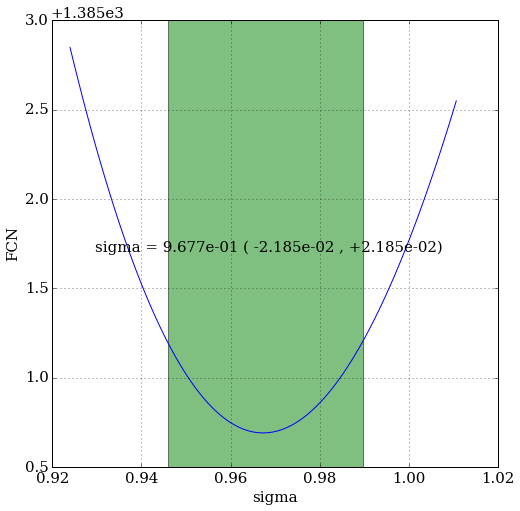

In [216]:
m.draw_profile('sigma') # wrapper to the above function

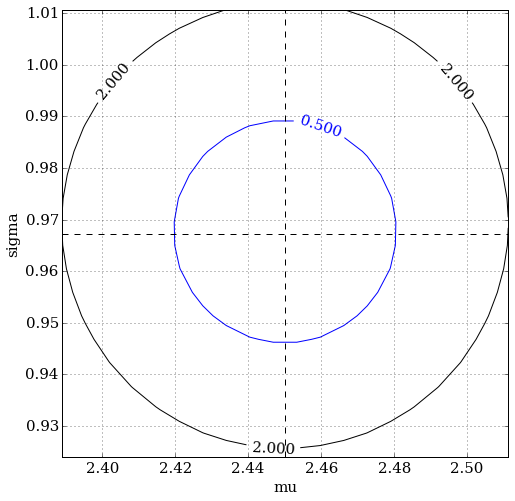

In [217]:
m.draw_contour('mu','sigma');

## Toy study

Now we want to do a little study to see how the parameter values and uncertainties vary between the two approaches. Simulate 500 datasets and fit to each one, first with scipy and then with MINUIT.

In [218]:
N = 500
minuit_vals = [np.zeros(N),np.zeros(N)]
minuit_errs = [np.zeros(N),np.zeros(N)]
minuit_nfcn = np.zeros(N)
bfgs_vals = [np.zeros(N),np.zeros(N)]
bfgs_errs = [np.zeros(N),np.zeros(N)]
bfgs_nfcn = np.zeros(N)
for i in range(N):
    s = np.random.normal(mu, sigma, 10000)
    def loglikelihood(params):
        """Need this for scipy.optimize"""
        myLL = LogLikelihood(gauss, s)
        return myLL(params[0], params[1])
    # BFGS appears to be quite sensitive to the tolerance required in this example. Default is 1e-5.
    # No concept of errdef here.
    res1 = minimize(loglikelihood, initial_values, method='BFGS', options = {'gtol':1e-3})
    NLL = LogLikelihood(gauss, s)
    # MINUIT appears to give a divide by zero error somewhere.
    # Note that the errdef in MINUIT has been set to 0.5 since this is an NLL fit
    m = Minuit(NLL, mu = initial_values[0], sigma = initial_values[1], limit_mu = (0., 10), limit_sigma = (0., 10), error_mu=1, error_sigma=1, print_level=0,errordef=0.5)
    res2 = m.migrad()
    if not res1.success: print "BFGS failed", i
    if not res2[0]['is_valid']: print "MINUIT failed", i
    bfgs_vals[0][i] = res1.x[0]
    bfgs_errs[0][i] = np.sqrt(res1.hess_inv[0][0])
    bfgs_vals[1][i] = res1.x[1]
    bfgs_errs[1][i] = np.sqrt(res1.hess_inv[1][1])
    bfgs_nfcn[i] = res1.nfev
    minuit_vals[0][i] = m.values['mu']
    minuit_errs[0][i] = m.errors['mu']
    minuit_vals[1][i] = m.values['sigma']
    minuit_errs[1][i] = m.errors['sigma']
    minuit_nfcn[i] = res2[0]['nfcn']

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
       mu = nan
    sigma = nan



In [219]:
res1

   status: 0
  success: True
     njev: 20
     nfev: 80
 hess_inv: array([[  1.00961892e-04,   3.52739432e-07],
       [  3.52739432e-07,   4.99368079e-05]])
      fun: 14173.921088782043
        x: array([ 2.50085193,  0.99845477])
  message: 'Optimization terminated successfully.'
      jac: array([ 0.,  0.])

Now plot the parameter values for each method and their difference. Same for the uncertainties.

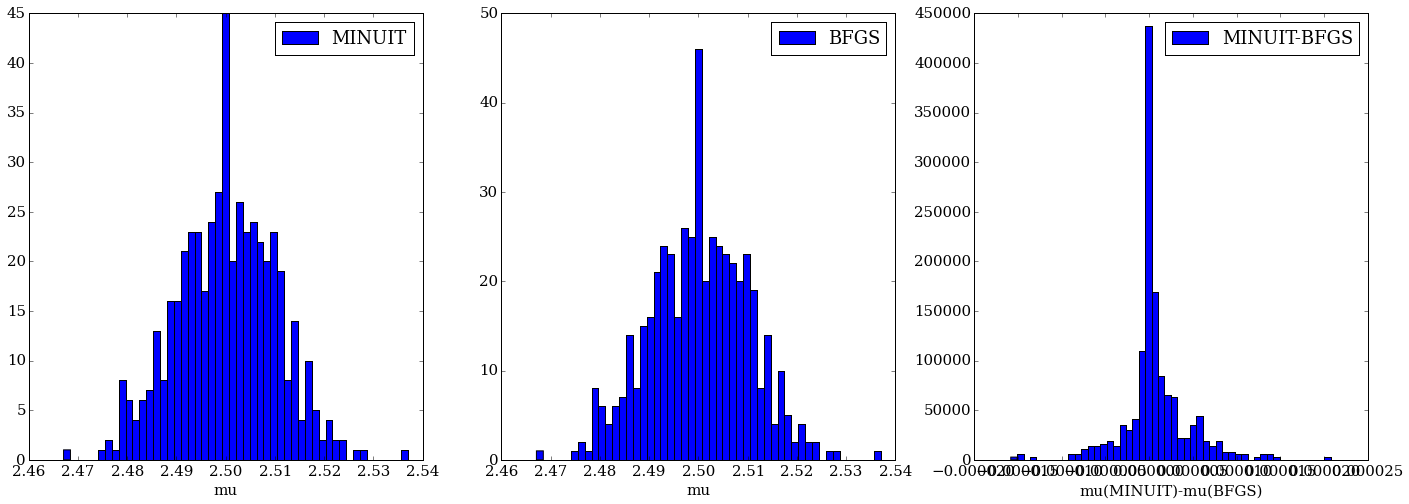

In [220]:
# mu value
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex = False, figsize=(24,8))
count, bins, ignored = ax1.hist(minuit_vals[0], 50, normed=False, label = "MINUIT")
count, bins, ignored = ax2.hist(bfgs_vals[0], 50, normed=False, label = "BFGS")
count, bins, ignored = ax3.hist((minuit_vals[0] - bfgs_vals[0])/(minuit_vals[0] + bfgs_vals[0]), 50, normed=True, label = "MINUIT-BFGS")
ax1.set_xlabel("mu")
ax2.set_xlabel("mu")
ax3.set_xlabel("mu(MINUIT)-mu(BFGS)")
ax1.legend()
ax2.legend()
ax3.legend()

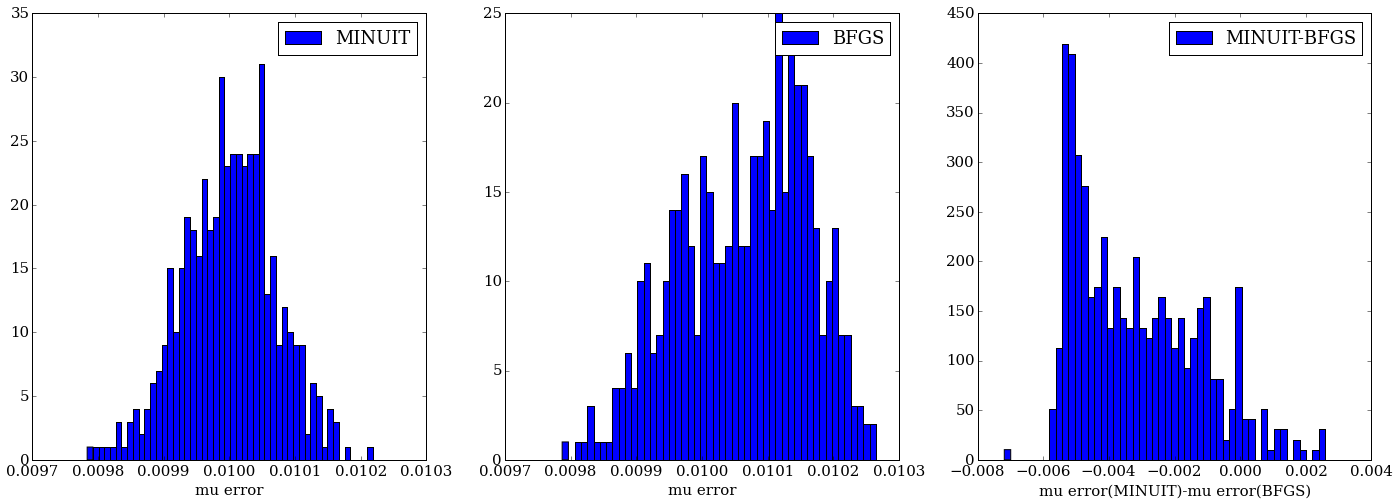

In [221]:
# mu error
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex = False, figsize=(24,8))
count, bins, ignored = ax1.hist(minuit_errs[0], 50, normed=False, label = "MINUIT")
count, bins, ignored = ax2.hist(bfgs_errs[0], 50, normed=False, label = "BFGS")
count, bins, ignored = ax3.hist((minuit_errs[0] - bfgs_errs[0])/(minuit_errs[0] + bfgs_errs[0]), 50, normed=True, label = "MINUIT-BFGS")
ax1.set_xlabel("mu error")
ax2.set_xlabel("mu error")
ax3.set_xlabel("mu error(MINUIT)-mu error(BFGS)")
ax1.legend()
ax2.legend()
ax3.legend()

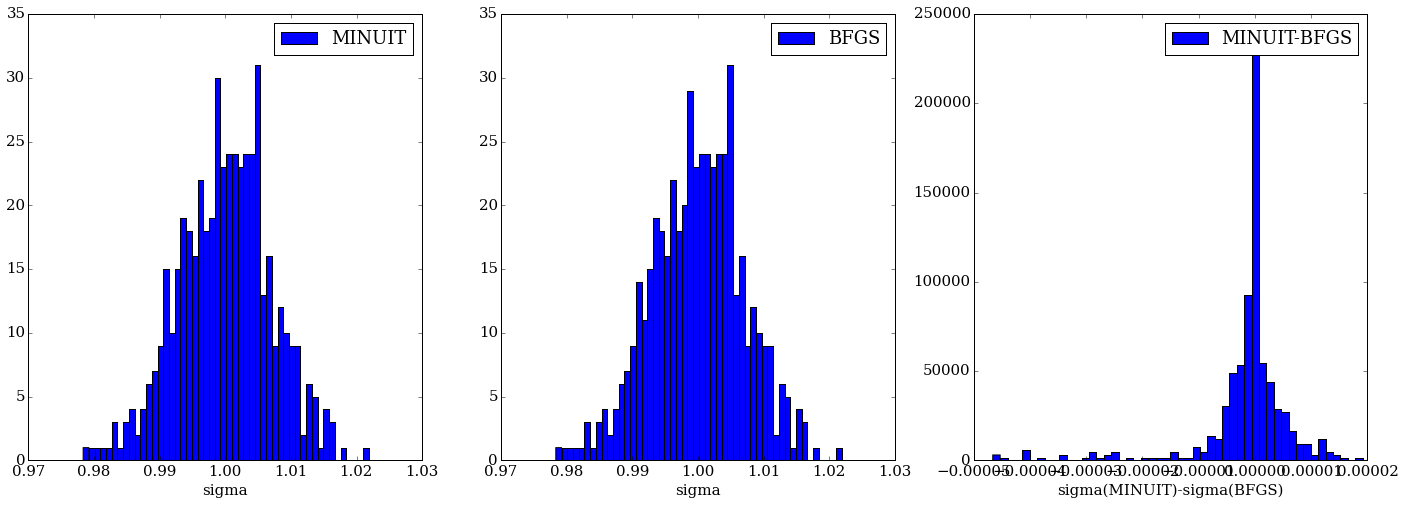

In [222]:
# sigma value
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex = False, figsize=(24,8))
count, bins, ignored = ax1.hist(minuit_vals[1], 50, normed=False, label = "MINUIT")
count, bins, ignored = ax2.hist(bfgs_vals[1], 50, normed=False, label = "BFGS")
count, bins, ignored = ax3.hist((minuit_vals[1] - bfgs_vals[1])/(minuit_vals[1] + bfgs_vals[1]), 50, normed=True, label = "MINUIT-BFGS")
ax1.set_xlabel("sigma")
ax2.set_xlabel("sigma")
ax3.set_xlabel("sigma(MINUIT)-sigma(BFGS)")
ax1.legend()
ax2.legend()
ax3.legend()

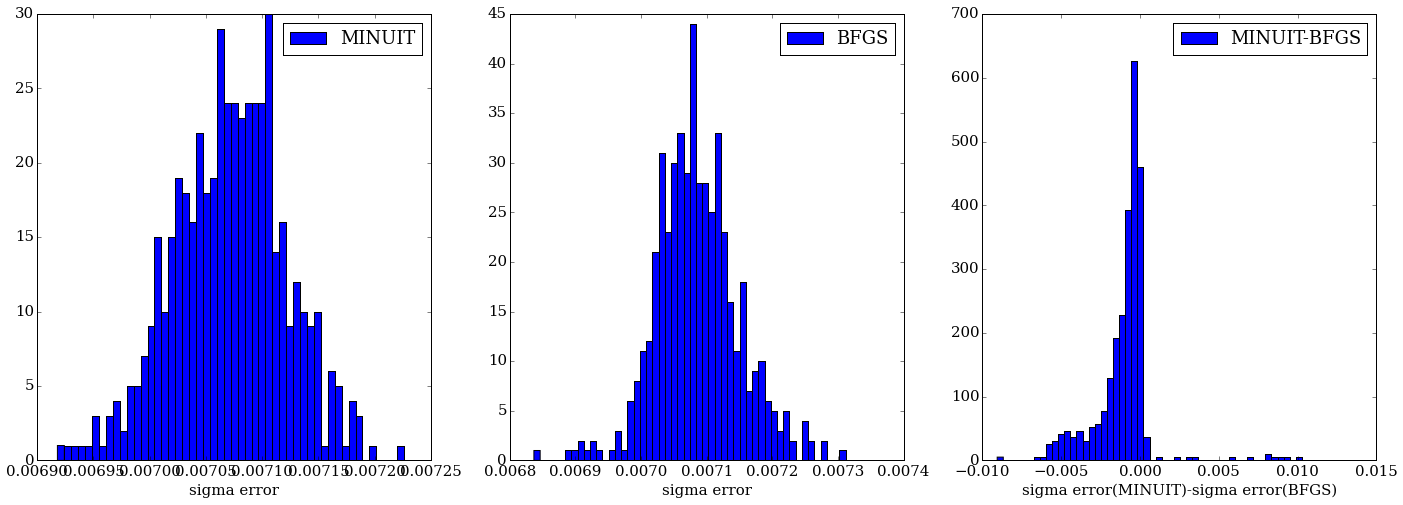

In [223]:
# sigma error
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex = False, figsize=(24,8))
count, bins, ignored = ax1.hist(minuit_errs[1], 50, normed=False, label = "MINUIT")
count, bins, ignored = ax2.hist(bfgs_errs[1], 50, normed=False, label = "BFGS")
count, bins, ignored = ax3.hist((minuit_errs[1] - bfgs_errs[1])/(minuit_errs[1] + bfgs_errs[1]), 50, normed=True, label = "MINUIT-BFGS")
ax1.set_xlabel("sigma error")
ax2.set_xlabel("sigma error")
ax3.set_xlabel("sigma error(MINUIT)-sigma error(BFGS)")
ax1.legend()
ax2.legend()
ax3.legend()

From the above we can see that the differences in the fitted values of the parameters are negligible. The differences in the unertainties can be up to 0.5-1.0%. We can also look at the number of function evaluations that each method needs for convergence. There is more of a spread for MINUIT, but on averge it needs fewer evaluations than scipy.

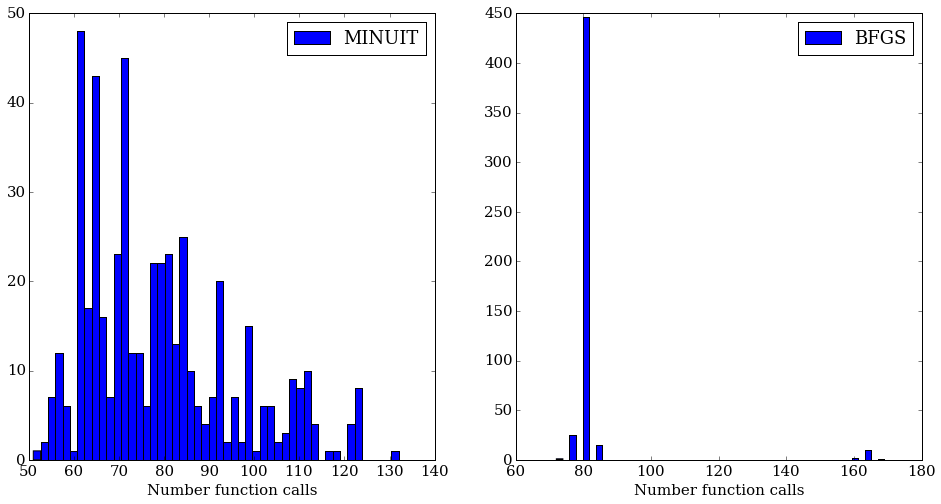

In [224]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex = False, figsize=(16,8))
count, bins, ignored = ax1.hist(minuit_nfcn, 50, normed=False, label = "MINUIT")
count, bins, ignored = ax2.hist(bfgs_nfcn, 50, normed=False, label = "BFGS")
ax1.set_xlabel("Number function calls")
ax2.set_xlabel("Number function calls")
ax1.legend()
ax2.legend()

There is some evidence that the default BFGS method in scipy is quite sensitive to the tolerance required for minimisation. MINUIT also allows to simultaneously have bounded parameters, provides the Hessian matrix at the end of minimisation and has nice in-built methods for visualising the fitted parameters and their correlations with each other.